In [437]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, ElasticNet
from pathlib import Path
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
import calendar
import os
import missingno as msno
import datetime as dt
import time

In [17]:
main_dir = Path('/Users/zach/Documents/git/thrasio')
data_dir = main_dir / 'Case_Study_Materials'
file_path = data_dir / 'CASE_STUDY_FINAL.csv'

In [18]:
dat_orig = pd.read_csv(file_path, low_memory=False)

In [19]:
dat_orig.shape

(266500, 7)

In [20]:
dat_orig.head()

,Date,SKU_mkt,Brand_ID,Total_Units,PPC_Units,PPC_Cost,Organic_Units
0,1/1/17,MODLB01GR1_US,1,1,1,-7.30,0
1,1/1/17,MODSSBL_US,1,9,0,-6.83,9
2,1/1/17,MODLB01GR2_US,1,8,1,-1.31,7
3,1/1/17,EO-AT4L-NSFF_US,2,31,0,0.00,31
4,1/1/17,IP-JZEN-Z9U7_US,2,128,0,0.00,128


In [21]:
dat_orig.dtypes

Date              object
SKU_mkt           object
Brand_ID           int64
Total_Units        int64
PPC_Units          int64
PPC_Cost         float64
Organic_Units      int64
dtype: object

In [12]:
dat_orig.describe()

,Brand_ID,Total_Units,PPC_Units,Organic_Units
count,266500.000000,266500.000000,266500.000000,266500.000000
mean,13.370863,20.714559,2.600931,18.113629
std,11.493332,48.484177,11.280347,43.101612
min,1.000000,0.000000,0.000000,-125.000000
25%,5.000000,2.000000,0.000000,2.000000
50%,11.000000,7.000000,0.000000,6.000000
75%,18.000000,20.000000,0.000000,18.000000
max,50.000000,6947.000000,937.000000,6947.000000


In [404]:
# uniqueness
dat_orig.nunique()

Date              1107
SKU_mkt            483
Brand_ID            50
Total_Units        614
PPC_Units          243
PPC_Cost         20092
Organic_Units      627
dtype: int64

In [405]:
dat = dat_orig.copy()

In [406]:
dat['datetime'] = pd.to_datetime(dat['Date'])
dat['date'] = dat['datetime'].dt.date

Create dimension tables for sku and date

In [407]:
dim_sku = pd.DataFrame(dat['SKU_mkt'].unique(),columns=['SKU_mkt'])

In [408]:
dim_sku['sku_num'] = list(range(dim_sku.shape[0]))

In [409]:
dim_date = pd.DataFrame(dat['datetime'].unique(),columns=['datetime'])

In [410]:
def assign_cycle_vars(df, suffix, var_pos, var_cycle_length):
    df['sin_term_'+suffix] = np.sin(df[var_pos]/df[var_cycle_length])
    df['cos_term_'+suffix] = np.cos(df[var_pos]/df[var_cycle_length])
    return None

In [411]:
dim_date['year'] = dim_date['datetime'].dt.year
dim_date['month'] = dim_date['datetime'].dt.month
dim_date['dayofyear'] = dim_date['datetime'].dt.dayofyear
dim_date['dayofmonth'] = dim_date['datetime'].dt.day
dim_date['dayofweek'] = dim_date['datetime'].dt.weekday
dim_date['days_in_month'] = [calendar.monthrange(y,m)[1] for y,m in zip(dim_date['year'], dim_date['month'])]
dim_date['days_in_year'] = [366 if calendar.isleap(y) else 365 for y in dim_date['year']]
dim_date['days_in_week'] = 7
dim_date['year_month'] = [str(y)+'-'+str(m) if m > 9 else str(y)+'-0'+str(m) for y,m in zip(dim_date['year'], dim_date['month'])]
assign_cycle_vars(dim_date, 'fracofyear', 'dayofyear', 'days_in_year')
assign_cycle_vars(dim_date, 'fracofmonth', 'dayofmonth', 'days_in_month')
assign_cycle_vars(dim_date, 'fracofweek', 'dayofweek', 'days_in_week')

In [434]:
dim_date['day_ordinal'] = dim_date['datetime'].rank(method='dense')
#TODO make rank for month_ordinal dense
dim_date['month_ordinal'] = dim_date['year_month'].rank(method='dense')
#TODO add lags for 1 day, 1 week
#TODO add weekenddates, monthenddate, yearenddate

In [435]:
dim_date[['year_month', 'month_ordinal']]

,year_month,month_ordinal
0,2017-01,1.0
1,2017-01,1.0
2,2017-01,1.0
3,2017-01,1.0
4,2017-01,1.0
...,...,...
1102,2020-01,37.0
1103,2020-01,37.0
1104,2020-01,37.0
1105,2020-01,37.0


Add dim table data to main dataset

In [414]:
dat = dat.merge(dim_sku, how='left', on='SKU_mkt')
dat = dat.merge(dim_date, how='left', on='datetime')

In [415]:
dat.head()

,Date,SKU_mkt,Brand_ID,Total_Units,PPC_Units,PPC_Cost,Organic_Units,datetime,date,sku_num,...,days_in_week,year_month,sin_term_fracofyear,cos_term_fracofyear,sin_term_fracofmonth,cos_term_fracofmonth,sin_term_fracofweek,cos_term_fracofweek,day_ordinal,month_ordinal
0,1/1/17,MODLB01GR1_US,1,1,1,-7.30,0,2017-01-01,2017-01-01,0,...,7,2017-01,0.00274,0.999996,0.032252,0.99948,0.755975,0.6546,1.0,16.0
1,1/1/17,MODSSBL_US,1,9,0,-6.83,9,2017-01-01,2017-01-01,1,...,7,2017-01,0.00274,0.999996,0.032252,0.99948,0.755975,0.6546,1.0,16.0
2,1/1/17,MODLB01GR2_US,1,8,1,-1.31,7,2017-01-01,2017-01-01,2,...,7,2017-01,0.00274,0.999996,0.032252,0.99948,0.755975,0.6546,1.0,16.0
3,1/1/17,EO-AT4L-NSFF_US,2,31,0,0.00,31,2017-01-01,2017-01-01,3,...,7,2017-01,0.00274,0.999996,0.032252,0.99948,0.755975,0.6546,1.0,16.0
4,1/1/17,IP-JZEN-Z9U7_US,2,128,0,0.00,128,2017-01-01,2017-01-01,4,...,7,2017-01,0.00274,0.999996,0.032252,0.99948,0.755975,0.6546,1.0,16.0


Inspect sample size for each sku

In [416]:
dat_groupby_sku = pd.DataFrame(dat[['sku_num', 'date','Total_Units']].groupby('sku_num').agg(
    {
        'date':('count','min','max'),
        'Total_Units':('min', 'max', np.mean)
    }).reset_index(drop=False))
dat_groupby_date = pd.DataFrame(dat[['date','sku_num']].groupby('date').agg(
    {
        'sku_num':'nunique'
    }).reset_index(drop=False))

In [422]:
dat_groupby_sku.columns = ['sku_num', 'count_date','min_date','max_date', 'min_Total_Units', 'max_Total_Units','mean_Total_Units']
dat_groupby_sku.sort_values('count_date',ascending=False)

,sku_num,count_date,min_date,max_date,min_Total_Units,max_Total_Units,mean_Total_Units
4,4,1107,2017-01-01,2020-01-12,0,628,78.520325
8,8,1107,2017-01-01,2020-01-12,1,212,14.496838
3,3,1106,2017-01-01,2020-01-12,0,134,42.506329
5,5,1106,2017-01-01,2020-01-12,0,394,123.086799
6,6,1105,2017-01-01,2020-01-12,0,89,9.455204
...,...,...,...,...,...,...,...
418,418,139,2019-01-18,2020-01-12,0,9,1.661871
266,266,139,2018-01-13,2019-09-24,0,11,1.992806
411,411,120,2018-11-11,2020-01-10,0,29,9.250000
408,408,110,2018-11-07,2019-04-24,0,15,4.563636


In [423]:
def days_between(d1, d2):
    d1 = dt.datetime.strptime(d1, "%Y-%m-%d")
    d2 = dt.datetime.strptime(d2, "%Y-%m-%d")
    return (d2 - d1).days+1

In [426]:
dat_groupby_sku['count_expected_date'] = [days_between(str(d1),str(d2)) for d1,d2 in zip(dat_groupby_sku['min_date'], dat_groupby_sku['max_date'])]
dat_groupby_sku['sku_has_expected_dates'] = [1 if c1==c2 else 0 for c1,c2 in zip(dat_groupby_sku['count_date'], dat_groupby_sku['count_expected_date'])]

In [433]:
dat_groupby_sku[dat_groupby_sku['sku_has_expected_dates'] == 0]


,sku_num,count_date,min_date,max_date,min_Total_Units,max_Total_Units,mean_Total_Units,count_expected_datetime,count_expected_date,sku_has_expected_dates
0,0,474,2017-01-01,2018-05-10,0,31,6.018987,495,495,0
1,1,215,2017-01-01,2019-09-27,0,371,7.418605,1000,1000,0
2,2,974,2017-01-01,2020-01-12,0,84,15.203285,1107,1107,0
3,3,1106,2017-01-01,2020-01-12,0,134,42.506329,1107,1107,0
5,5,1106,2017-01-01,2020-01-12,0,394,123.086799,1107,1107,0
...,...,...,...,...,...,...,...,...,...,...
475,475,161,2019-06-18,2020-01-12,0,78,8.316770,209,209,0
476,476,176,2019-07-01,2020-01-12,0,269,20.346591,196,196,0
479,479,174,2019-07-22,2020-01-12,1,31,10.637931,175,175,0
480,480,150,2019-07-28,2020-01-12,0,18,2.580000,169,169,0


In [235]:
#TODO correlations between PPC cost and PPC units/organic units

Date                    1107
SKU_mkt                    7
Brand_ID                   1
Total_Units               60
PPC_Units                 21
PPC_Cost                1509
Organic_Units             59
datetime                1107
sku_num                    7
year                       4
month                     12
dayofyear                365
dayofmonth                31
dayofweek                  7
days_in_month              3
days_in_year               2
days_in_week               1
sin_term_fracofyear      377
cos_term_fracofyear      377
sin_term_fracofmonth      86
cos_term_fracofmonth      86
sin_term_fracofweek        7
cos_term_fracofweek        7
trend                   1107
dtype: int64

In [ ]:
#TODO establish training/test data
#TODO prepare cross validation framework
#TODO implement naive model: predict previous day
#TODO send josh questions about 
#TODO install pystan or other hierarchical model
#(1) predicting out how far? what's our forecast lead time? 
#(2) predicting by day?
#(3) how far ahead of time do we know what our PPC cost is? if it's day t and we're predicting the sales for day t+h, do we know the ppc cost for day t,t+1,...,t+h?
#(4) if a product's sales "end", do we still forecast it?

In [298]:
def logify(x):
    return np.log(x - np.min(x) + 1)

In [316]:
dat['log_Total_Units'] = logify(dat['Total_Units'])
dat['log_Organic_Units'] = logify(dat['Organic_Units'])
dat['log_PPC_Units'] = logify(dat['PPC_Units'])
dat['PPC_Cost'] = -1*dat['PPC_Cost']
dat['log_PPC_Cost'] = logify(dat['PPC_Cost'])

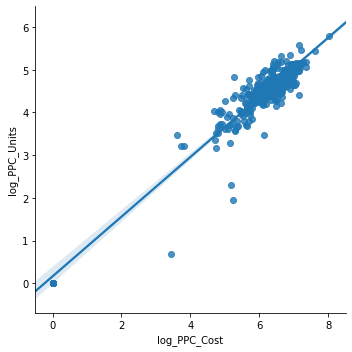

In [345]:
#fig,ax=plt.subplots(1,2)
sns.lmplot(x='log_PPC_Cost',y='log_PPC_Units',data=dat[dat['sku_num'] == 420])

In [350]:
pd.DataFrame(dat.groupby(['sku_num']).cumcount()

0           0
1           0
2           0
3           0
4           0
         ... 
266495    404
266496    445
266497    537
266498    256
266499    402
Length: 266500, dtype: int64

AttributeError: module 'datetime' has no attribute 'time_delta'